In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

E0000 00:00:1753183691.131741      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230
Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Config
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 150
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./output_conformer_training_tpu")
BEST_MODEL_PATH = OUTPUT_DIR / "transformer_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753183729.178482      10 service.cc:148] XLA service 0x5c5026197d40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753183729.178528      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753183729.178533      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753183729.178536      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753183729.178538      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753183729.178541      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753183729.178544      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753183729.178546      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753183729.178549      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
print("\nLoading all compressed features")

# Load the compressed .npz files
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33043, 150, 768)
y_train shape: (33043, 6)


In [7]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

Data loaded and modified successfully.
New X_train shape: (28881, 150, 768)


In [8]:
print("\n Verifying final training set distribution after augmentation")

# Convert the y_train numpy array to a pandas DataFrame to easily count labels
final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10203
WordRep         10040
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Transformer Model")
    # Transformer Encoder Block 
    def transformer_encoder(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Attention and Normalization
        x_attn = layers.LayerNormalization(epsilon=1e-6)(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Network
        x_ff = layers.LayerNormalization(epsilon=1e-6)(x)
        x_ff = layers.Dense(ff_dim, activation="relu")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection
        
        return x

    def build_transformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs
        
        # Applies Transformer encoder blocks
        x = transformer_encoder(x, num_heads=4, ff_dim=256)
        x = transformer_encoder(x, num_heads=4, ff_dim=256)
        
        # Pool the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)
        
        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_transformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


Building Transformer Model


I0000 00:00:1753184229.972953      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 150, 768)  │      1,536 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 150, 768)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 150, 768)  │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 150, 256)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 150, 768)  │    197,376 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 150, 768)  │          0 │ add[0][0],        │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 150, 768)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 150, 768)  │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 150, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 150, 768)  │    197,376 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 150, 768)  │          0 │ add_2[0][0],      │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,618,437 (21.43 MB)

 Trainable params: 5,618,437 (21.43 MB)

 Non-trainable params: 0 (0.00 B)

LEARNING RATE: 1e-05
BATCH SIZE: 128


In [11]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/150


I0000 00:00:1753184277.717771      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16268412476456840601
I0000 00:00:1753184278.880339     812 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7513875852996281865), session_name()
I0000 00:00:1753184290.186732     812 tpu_compile_op_common.cc:245] Compilation of 7513875852996281865 with session name  took 11.306337834s and succeeded
I0000 00:00:1753184290.224472     812 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7513875852996281865), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16268412476456840601", property.function_library_fingerprint = 2212797070942526644, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().

225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2677 - auc: 0.5550 - loss: 0.6856 - precision: 0.4441 - recall: 0.2558

I0000 00:00:1753184299.177413     831 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9326965528359042818), session_name()
I0000 00:00:1753184308.812386     831 tpu_compile_op_common.cc:245] Compilation of 9326965528359042818 with session name  took 9.634933527s and succeeded
I0000 00:00:1753184308.847309     831 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9326965528359042818), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16268412476456840601", property.function_library_fingerprint = 2212797070942526644, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;11,5,;", property.guaranteed_constants_size = 0, embedding_pa

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2677 - auc: 0.5552 - loss: 0.6855 - precision: 0.4443 - recall: 0.2556

I0000 00:00:1753184325.085118      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17816368483032493623
I0000 00:00:1753184325.517630     799 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7553574565304873982), session_name()
I0000 00:00:1753184327.520602     799 tpu_compile_op_common.cc:245] Compilation of 7553574565304873982 with session name  took 2.002908815s and succeeded
I0000 00:00:1753184327.526876     799 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7553574565304873982), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_17816368483032493623", property.function_library_fingerprint = 16299149636099302676, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().


Epoch 1: val_auc improved from -inf to 0.66509, saving model to output_conformer_training_tpu/best_conformer_model_tpu.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 67s 173ms/step - accuracy: 0.2676 - auc: 0.5553 - loss: 0.6853 - precision: 0.4444 - recall: 0.2555 - val_accuracy: 0.1577 - val_auc: 0.6651 - val_loss: 0.6397 - val_precision: 0.5723 - val_recall: 0.2295
Epoch 2/150
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2783 - auc: 0.6336 - loss: 0.6253 - precision: 0.5639 - recall: 0.2867
Epoch 2: val_auc improved from 0.66509 to 0.68593, saving model to output_conformer_training_tpu/best_conformer_model_tpu.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step - accuracy: 0.2783 - auc: 0.6338 - loss: 0.6253 - precision: 0.5640 - recall: 0.2869 - val_accuracy: 0.1530 - val_auc: 0.6859 - val_loss: 0.6438 - val_precision: 0.5145 - val_recall: 0.2705
Epoch 3/150
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2802 - auc: 0.6470 - loss: 0.6232 - precision: 0.5787 - recall: 0.3229



Evaluating Model on the Test Set


I0000 00:00:1753185620.842903      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16901305469887961219
E0000 00:00:1753185620.867360      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753185620.939810     801 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5569639040946747444), session_name()
I0000 00:00:1753185622.644527     801 tpu_compile_op_common.cc:245] Compilation of 5569639040946747444 with session name  took 1.704655914s and succeeded
I0000 00:00:1753185622.647869     801 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5569639040946747444), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_16901305469887961219", property.function_library_fingerprint = 3136207583786936660, property.mlir_module_fingerprint

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

I0000 00:00:1753185627.558726      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4150484324106321972
I0000 00:00:1753185627.806234     738 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16983742599322048262), session_name()
I0000 00:00:1753185629.211037     738 tpu_compile_op_common.cc:245] Compilation of 16983742599322048262 with session name  took 1.404754516s and succeeded
I0000 00:00:1753185629.214057     738 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16983742599322048262), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_4150484324106321972", property.function_library_fingerprint = 6734680035167650444, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topo

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step

 Classification Report (5 Stuttering Classes) 
              precision    recall  f1-score   support

Prolongation       0.61      0.52      0.56      2613
       Block       0.61      0.51      0.56      3501
    SoundRep       0.59      0.49      0.53      1891
     WordRep       0.56      0.39      0.46      1742
Interjection       0.87      0.61      0.71      3344

   micro avg       0.66      0.52      0.58     13091
   macro avg       0.65      0.50      0.57     13091
weighted avg       0.67      0.52      0.58     13091
 samples avg       0.62      0.54      0.54     13091


Generating plots for model training history


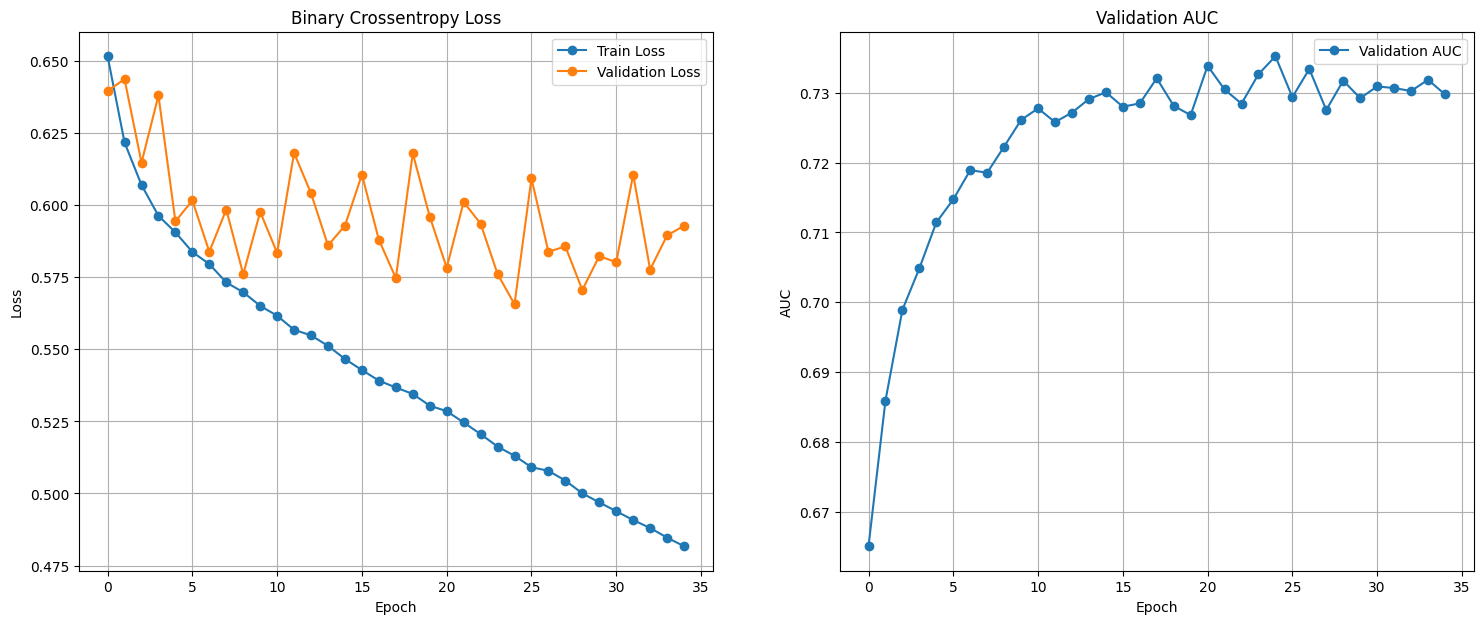

In [ ]:
print("\nEvaluating Model on the Test Set")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n Classification Report (5 Stuttering Classes) ")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\nGenerating plots for model training history")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

